# [Draft] Poroelasticity

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh

file = "grids/horizontal.msh"

gridView = mmesh((reader.gmsh, file), 2)
igridView = gridView.hierarchicalGrid.interfaceGrid

In [2]:
from ufl import *
from dune.ufl import Constant

E = 1
nu = 0.3
lamb = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

alpha = 1
K = 1
p_gamma = 1e3

epsilon   = lambda u: 0.5 * (nabla_grad(u) + nabla_grad(u).T)
sigma_eff = lambda u: lamb * nabla_div(u) * Identity(2) + 2 * mu * epsilon(u)
sigma     = lambda u, p: sigma_eff(u) - alpha * p * Identity(2)

In [3]:
from dune.fem.space import dglagrange

space = dglagrange(gridView, dimRange=3, order=1)

trial = TrialFunction(space)
test = TestFunction(space)

p,  ux,  uy  = split(trial)
pp, uux, uuy = split(test)

u  = as_vector([ux,  uy ])
uu = as_vector([uux, uuy])

x = SpatialCoordinate(space)
n = FacetNormal(space)

In [4]:
from dune.mmesh import skeleton, trace, interfaceIndicator

I = interfaceIndicator(igridView)
beta = Constant(1e3, name="beta")

a = inner(sigma(u, p), epsilon(uu)) * dx
a += inner(K * grad(p), grad(pp)) * dx

a += beta * inner(jump(u), jump(uu)) * (1-I)*dS
a += beta * inner(jump(p), jump(pp)) * (1-I)*dS

a += beta * inner(as_vector([0,0]) - u, uu) * ds
a += beta * (0 - p) * pp * ds

# normal stress is -p
a += -p_gamma * inner(uu('+'), n('+')) * I*dS
a += -p_gamma * inner(uu('-'), n('-')) * I*dS

# pressure is continuous
a += beta * (p_gamma - p('+')) * pp('+') * I*dS
a += beta * (p_gamma - p('-')) * pp('-') * I*dS

# consistency terms
# a -= dot(dot(avg(sigma(u,p)), n('+')), jump(uu)) * dS
# a -= dot(dot(avg(epsilon(uu)), n('+')), jump(u)) * dS
# a -= inner(avg(K*grad(p)), n('+')) * jump(pp) * dS
# a -= inner(avg(K*grad(pp)), n('+')) * jump(p) * dS

a -= dot(dot(sigma(u,p), n), uu) * ds
a -= dot(dot(epsilon(uu), n), u) * ds
a -= inner(K*grad(p), n) * pp * ds
a -= inner(K*grad(pp), n) * p * ds

In [5]:
from dune.fem.scheme import galerkin
scheme = galerkin([a == 0], solver=("suitesparse", "umfpack"))
solution = space.interpolate([0,0,0], name="solution")
res = scheme.solve(target=solution)

DUNE-INFO: Compiling Scheme


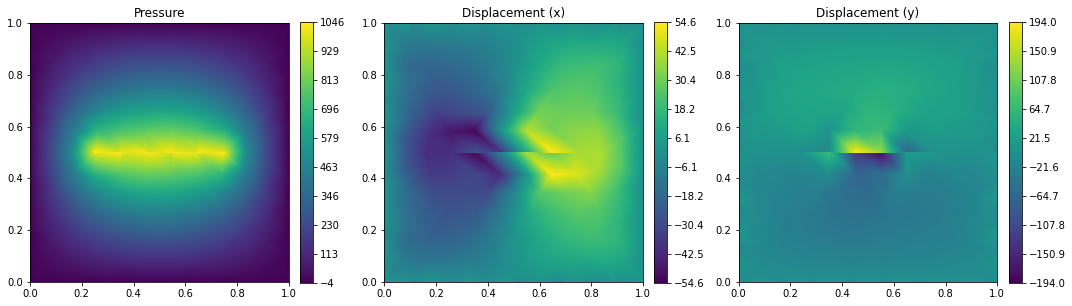

In [6]:
import matplotlib.pyplot as plt
from dune.fem.plotting import plotPointData as plot

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].set_title('Pressure')
plot(solution[0], figure=(fig, axs[0]), gridLines=None)
axs[1].set_title('Displacement (x)')
plot(solution[1], figure=(fig, axs[1]), gridLines=None)
axs[2].set_title('Displacement (y)')
plot(solution[2], figure=(fig, axs[2]), gridLines=None)